### Načtení potřebných balíčků

In [1]:
include("helpers.jl")
import GR

In [2]:
using DataFrames, CSV , PyPlot, XLSX, Statistics, Dates #, ...

# Mauna Loa

#### Načtení datasetu

In [3]:
df = CSV.read("./data/monthly_in_situ_co2_mlo.csv", DataFrame)
first(df, 5)

,Yr,Mn,Date,Date_1,CO2,seasonally,fit,seasonally_1,CO2_1
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1958,1,21200,1958.04,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,2,21231,1958.13,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,3,21259,1958.2,315.71,314.43,316.2,314.91,315.71
4,1958,4,21290,1958.29,317.45,315.16,317.3,314.99,317.45
5,1958,5,21320,1958.37,317.51,314.7,317.88,315.06,317.51


#### Zahození nechtěných sloupců

In [4]:
df = df[:, ["Yr", "Mn", "CO2"]]
first(df, 5)

,Yr,Mn,CO2
,Int64,Int64,Float64
1,1958,1,-99.99
2,1958,2,-99.99
3,1958,3,315.71
4,1958,4,317.45
5,1958,5,317.51


#### Odebrání řádků s chybějící hodnotou

In [5]:
filter!(row -> row.CO2 != -99.99, df)
first(df, 5)

,Yr,Mn,CO2
,Int64,Int64,Float64
1,1958,3,315.71
2,1958,4,317.45
3,1958,5,317.51
4,1958,7,315.87
5,1958,8,314.93


### Vizualizace množství CO2 v letech

* k vizualizaci jsem využil PyPlot
* z grafu je patrné, že množství CO2 roste

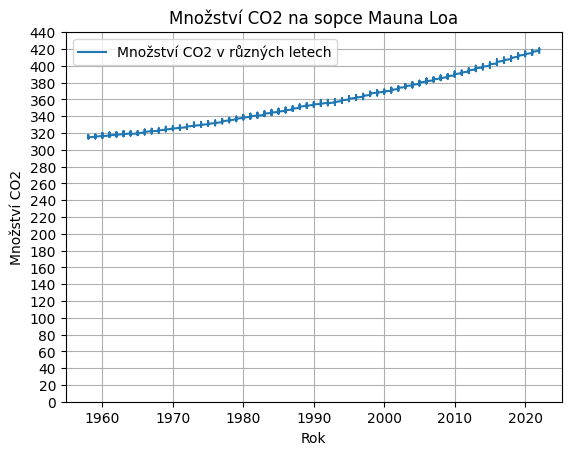

In [6]:
figure()
plot(df[:, :Yr], df[:, :CO2], label="Množství CO2 v různých letech")
xlabel("Rok")
ylabel("Množství CO2")
title("Množství CO2 na sopce Mauna Loa")
yticks([x for x in 0:20:440])
grid()
legend()
plt[:show]()

### Jaký model vystihuje data nejlépe?

* Jako vysvětlovanou proměnnou zvolím CO2

#### Příprava dat pro trénování

In [7]:
xs = Float64[x for x in df[:, :Yr]] # přetypování příznaku Year na stejný jako CO2
ys = df[:, :CO2]
ws = ones(nrow(df)) # váhy datových bodů
fs_lin = [ x -> 1, x -> x ] # lineární funkce
fs_quad = [ x -> 1, x -> x, x -> x ^ 2 ] # kvadratická funkce

3-element Vector{Function}:
 #7 (generic function with 1 method)
 #8 (generic function with 1 method)
 #9 (generic function with 1 method)

#### Natrénování koeficientů lineární a kvadratické funkce odhadující příznak CO2

In [8]:
fit_lin = Helpers.fitWLS(xs, ys, ws, fs_lin) 
println("Koeficienty lineární funkce:\n", fit_lin)
fit_quad = Helpers.fitWLS(xs, ys, ws, fs_quad)
println("Koeficienty kvadratické funkce:\n", fit_quad)

Koeficienty lineární funkce:
[-2851.009410304985, 1.6122387211327343]
Koeficienty kvadratické funkce:
[50120.5843248993, -51.62671289843748, 0.013375747879285348]


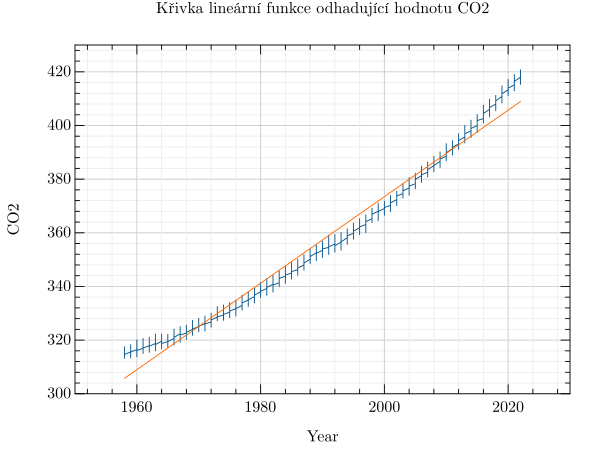

In [9]:
GR.title("Křivka lineární funkce odhadující hodnotu CO2")
GR.scatter(xs, ys)
GR.xlabel("Year")
GR.ylabel("CO2")
GR.oplot(xs, [ fit_lin[1] + fit_lin[2] * x for x in xs ])

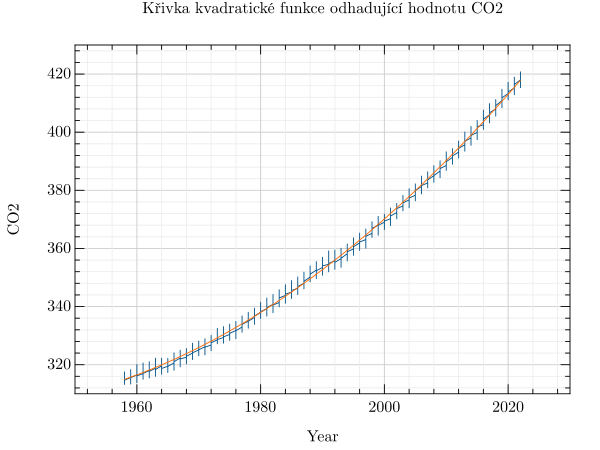

In [10]:
GR.title("Křivka kvadratické funkce odhadující hodnotu CO2")
GR.scatter(xs, ys)
GR.xlabel("Year")
GR.ylabel("CO2")
GR.oplot(xs, [ fit_quad[1] + fit_quad[2] * x + fit_quad[3] * x ^ 2 for x in xs ])

* Jednoznačně popisuje kvadratická funkce trend růstu CO2 lépe.

# Klementinum

#### Načtení dataframu

In [11]:
df = DataFrame(XLSX.readtable("./data/PKLM_pro_portal.xlsx", "data"))
first(df, 5)

,rok,měsíc,den,AVG,TMA,TMI,SRA,Flag
,Any,Any,Any,Any,Any,Any,Any,Any
1,1775,1,1,-7.0,-4.8,-10.1,missing,missing
2,1775,1,2,-2.2,-1.4,-5.8,missing,missing
3,1775,1,3,-1.0,0.6,-2.2,missing,missing
4,1775,1,4,0.1,2.5,-3.6,missing,missing
5,1775,1,5,2.2,3.0,1.6,missing,missing


### Odstranění nepotřebných sloupců

In [12]:
df = df[:, [:rok, :měsíc, :den, :AVG, :TMA, :TMI]]
first(df, 5)

,rok,měsíc,den,AVG,TMA,TMI
,Any,Any,Any,Any,Any,Any
1,1775,1,1,-7.0,-4.8,-10.1
2,1775,1,2,-2.2,-1.4,-5.8
3,1775,1,3,-1.0,0.6,-2.2
4,1775,1,4,0.1,2.5,-3.6
5,1775,1,5,2.2,3.0,1.6


### Spočítání průměrné teploty v měsíci z průměrných teplot jednotlivých dní v daném měsíci pro každý měsíc

In [13]:
avg_years = combine(groupby(df[:, [:rok, :měsíc, :den, :AVG]], [:rok, :měsíc]), :AVG .=> mean .=> :AVG )
first(avg_years, 5)

,rok,měsíc,AVG
,Any,Any,Float64
1,1775,1,0.174194
2,1775,2,5.06429
3,1775,3,6.38387
4,1775,4,7.26667
5,1775,5,14.0581


### Rozdělení datasetu průměrných teplot do 12 skupin podle měsíce

In [14]:
avg_months = groupby(avg_years, :měsíc)
for i in 1:3
    print(first(avg_months[i], 3))
end

3×3 DataFrame
 Row │ rok   měsíc  AVG       
     │ Any   Any    Float64   
─────┼────────────────────────
   1 │ 1775  1       0.174194
   2 │ 1776  1      -8.13871
   3 │ 1777  1      -1.425813×3 DataFrame
 Row │ rok   měsíc  AVG     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  2      5.06429
   2 │ 1776  2      3.68621
   3 │ 1777  2      0.13×3 DataFrame
 Row │ rok   měsíc  AVG     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  3      6.38387
   2 │ 1776  3      5.45806
   3 │ 1777  3      4.34516

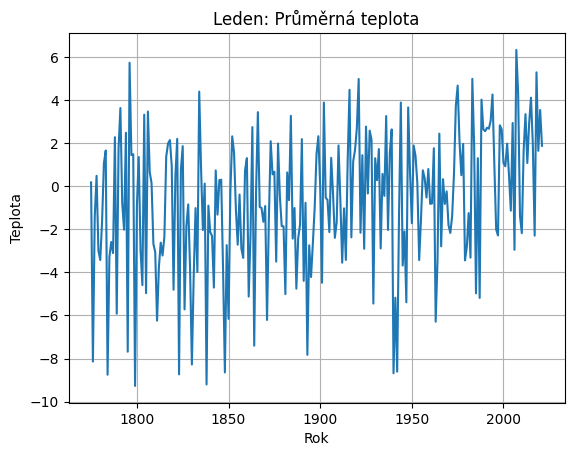

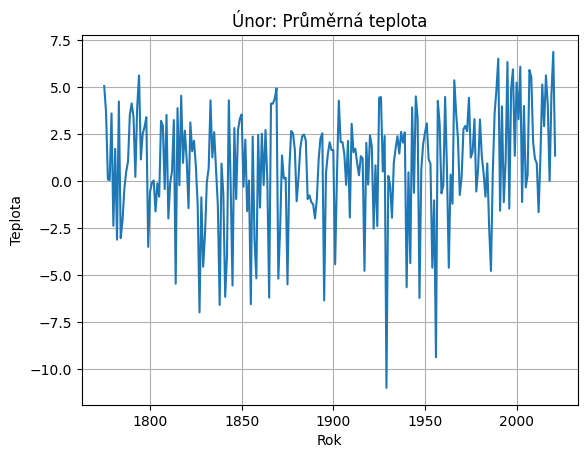

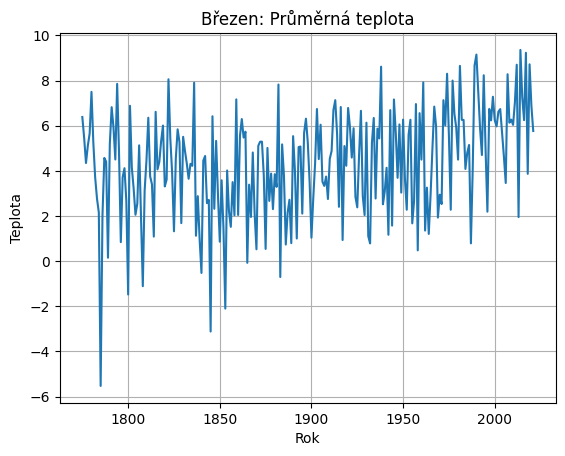

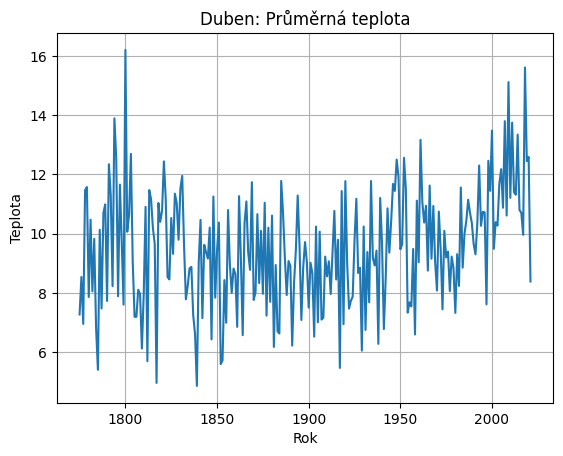

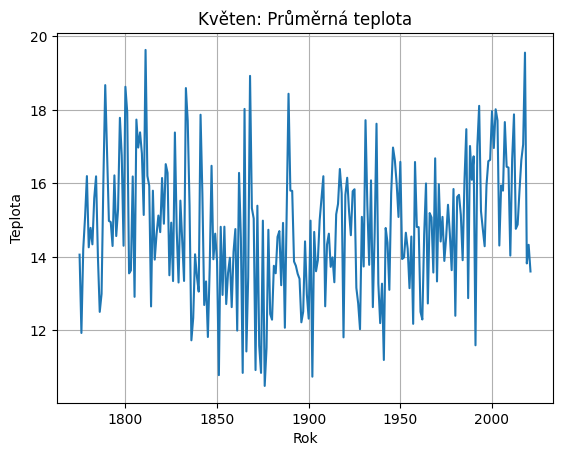

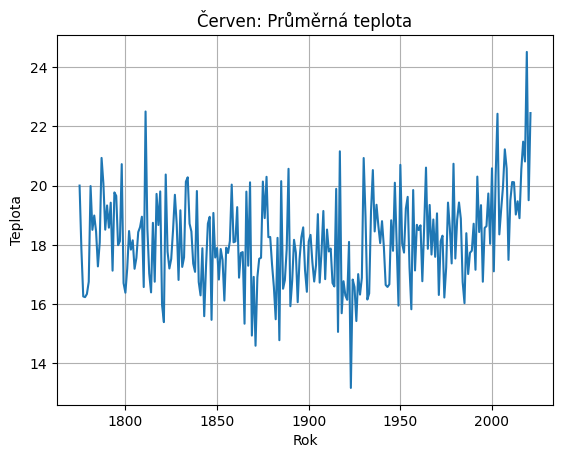

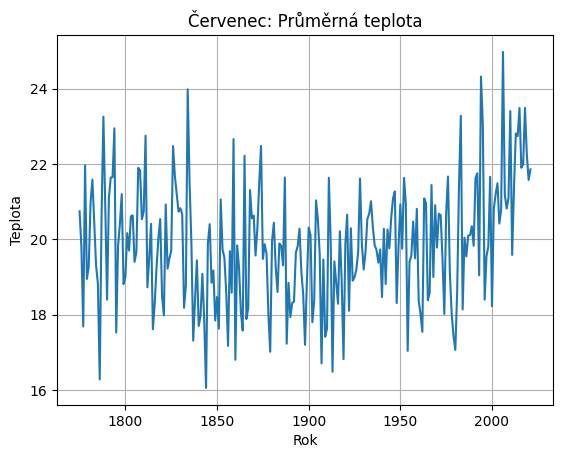

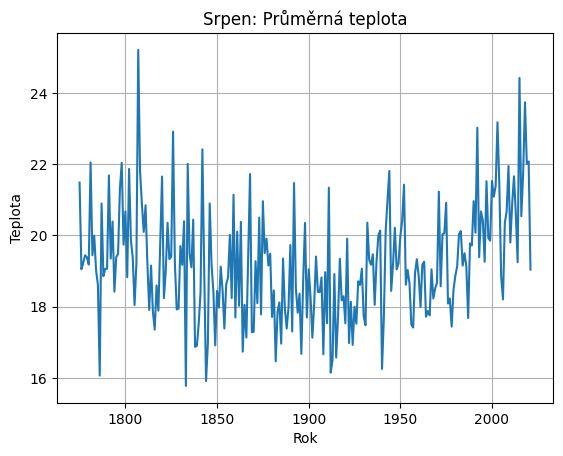

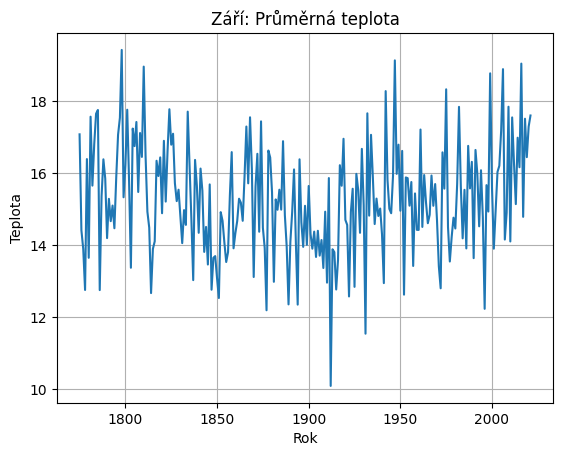

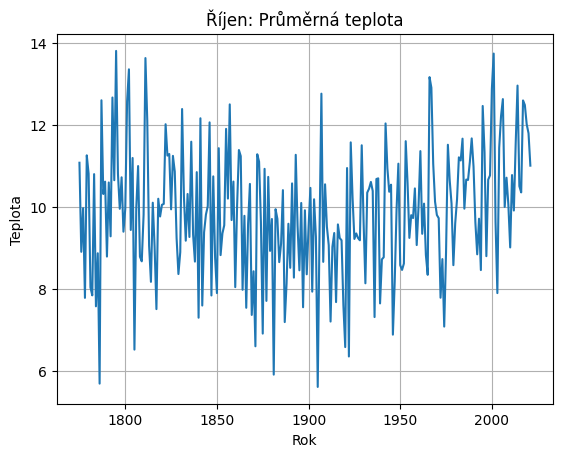

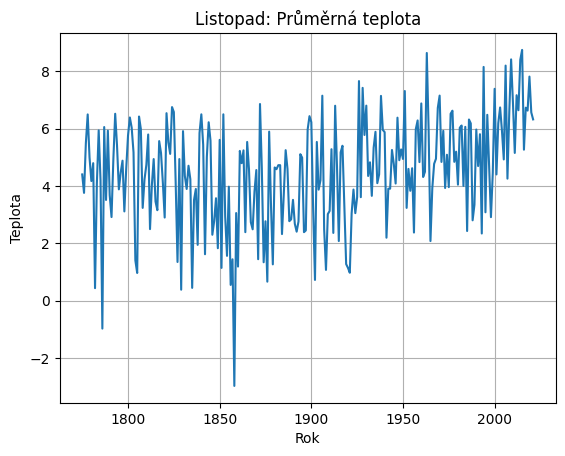

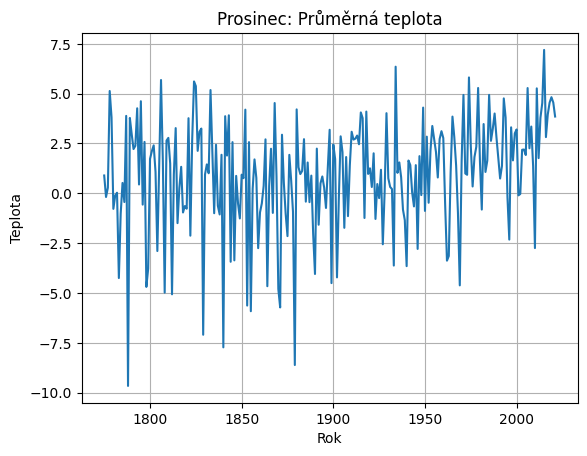

In [15]:
for i in 1:12
    figure()
    tmp = avg_months[(i)]
    plot(tmp[:, :rok], tmp[:, :AVG], label="Vývoj teploty")
    xlabel("Rok")
    ylabel("Teplota")
    title(Helpers.getMonth(i)*": Průměrná teplota")
    grid()
    plt[:show]()
end

### Spočítání maximální teploty v měsíci z maximálních teplot jednotlivých dní v daném měsíci pro každý měsíc

In [16]:
max_years = combine(groupby(df[:, [:rok, :měsíc, :den, :TMA]], [:rok, :měsíc]), :TMA .=> maximum .=> :TMA )
first(max_years, 5)

,rok,měsíc,TMA
,Any,Any,Float64
1,1775,1,10.5
2,1775,2,15.4
3,1775,3,14.2
4,1775,4,23.1
5,1775,5,23.1


### Rozdělení datasetu maximálních teplot do 12 skupin podle měsíce

In [17]:
max_months = groupby(max_years, :měsíc)
for i in 1:3
    print(first(max_months[i], 3))
end

3×3 DataFrame
 Row │ rok   měsíc  TMA     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  1         10.5
   2 │ 1776  1          2.2
   3 │ 1777  1          6.23×3 DataFrame
 Row │ rok   měsíc  TMA     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  2         15.4
   2 │ 1776  2         13.1
   3 │ 1777  2          7.33×3 DataFrame
 Row │ rok   měsíc  TMA     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  3         14.2
   2 │ 1776  3         17.5
   3 │ 1777  3         18.4

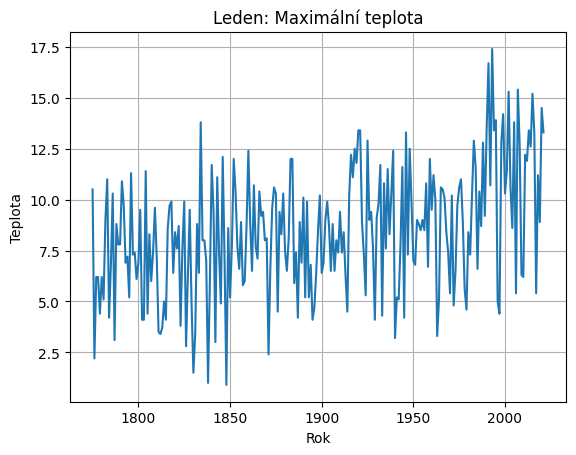

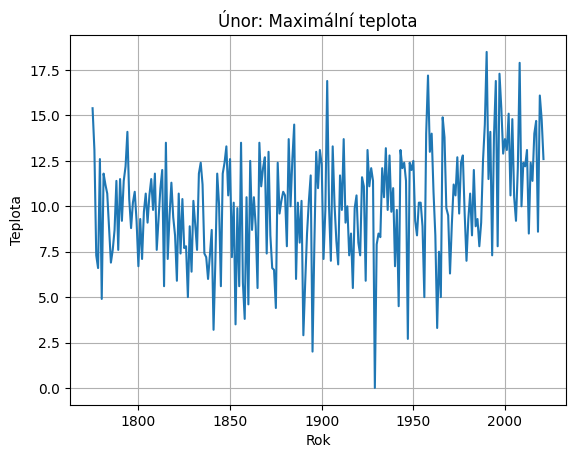

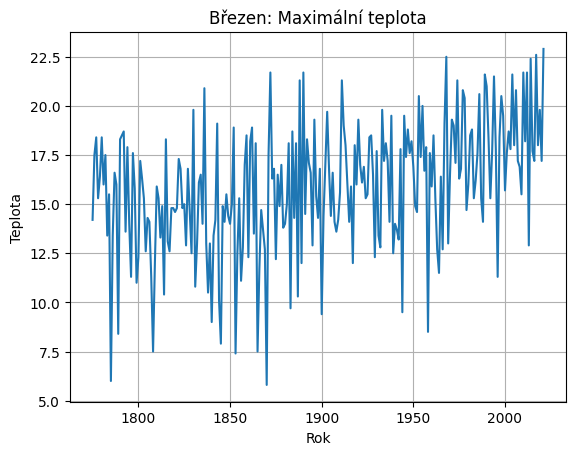

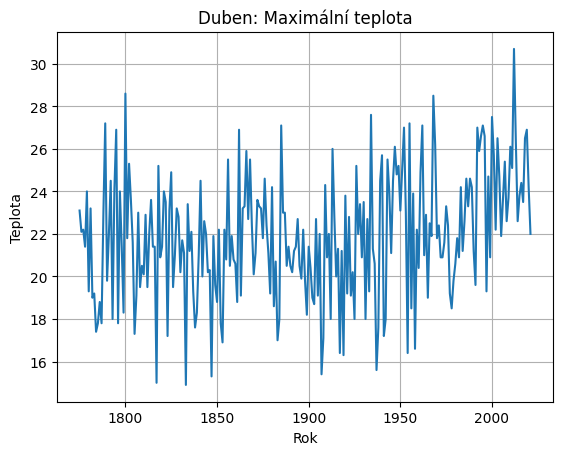

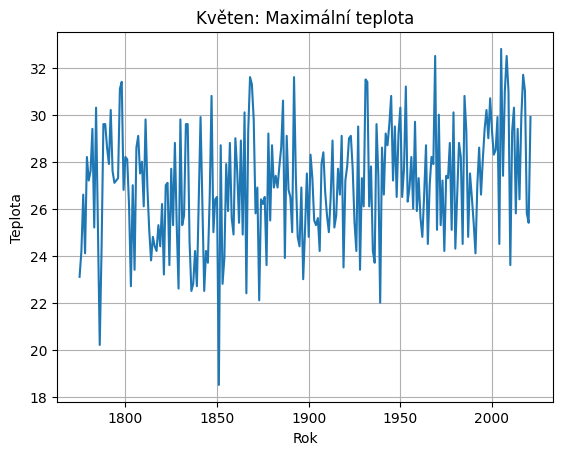

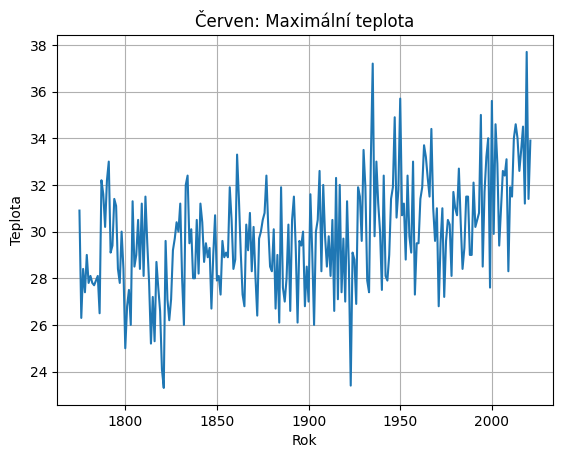

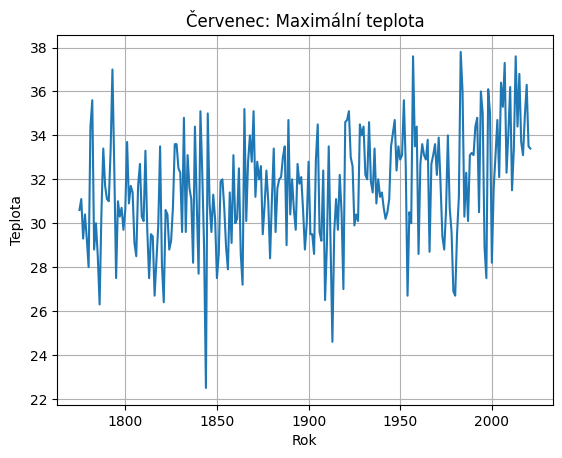

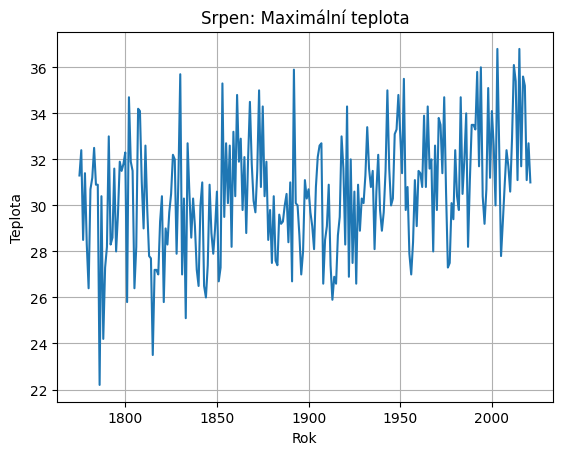

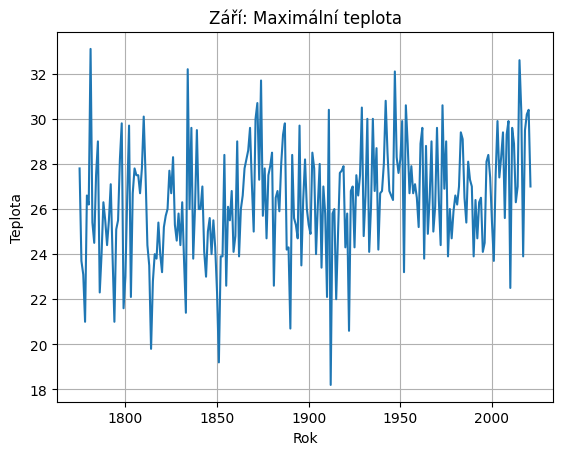

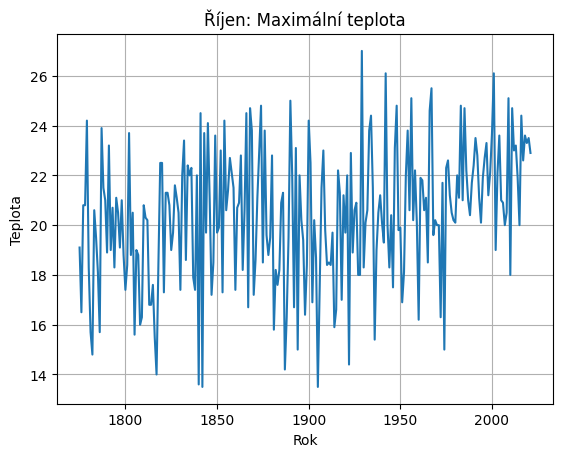

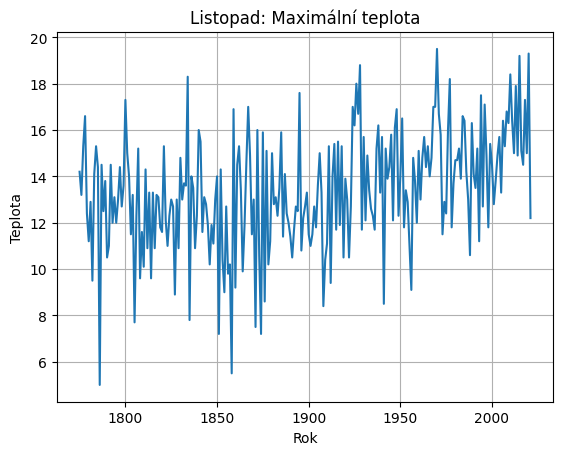

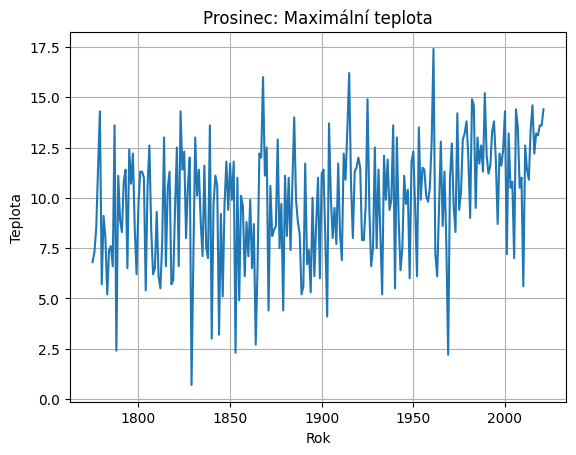

In [18]:
for i in 1:12
    figure()
    tmp = max_months[(i)]
    plot(tmp[:, :rok], tmp[:, :TMA])
    xlabel("Rok")
    ylabel("Teplota")
    title(Helpers.getMonth(i)*": Maximální teplota")
    grid()
    plt[:show]()
end

### Spočítání minimální teploty v měsíci z minimálních teplot jednotlivých dní v daném měsíci pro každý měsíc

In [19]:
min_years = combine(groupby(df[:, [:rok, :měsíc, :den, :TMI]], [:rok, :měsíc]), :TMI .=> minimum .=> :TMI )
first(min_years, 5)

,rok,měsíc,TMI
,Any,Any,Float64
1,1775,1,-16.0
2,1775,2,-9.1
3,1775,3,-2.8
4,1775,4,-3.3
5,1775,5,4.6


### Rozdělení datasetu minimálních teplot do 12 skupin podle měsíce

In [20]:
min_months = groupby(min_years, :měsíc)
for i in 1:3
    print(first(min_months[i], 3))
end

3×3 DataFrame
 Row │ rok   měsíc  TMI     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  1        -16.0
   2 │ 1776  1        -22.7
   3 │ 1777  1        -10.33×3 DataFrame
 Row │ rok   měsíc  TMI     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  2         -9.1
   2 │ 1776  2        -21.5
   3 │ 1777  2         -8.03×3 DataFrame
 Row │ rok   měsíc  TMI     
     │ Any   Any    Float64 
─────┼──────────────────────
   1 │ 1775  3         -2.8
   2 │ 1776  3         -0.7
   3 │ 1777  3         -5.2

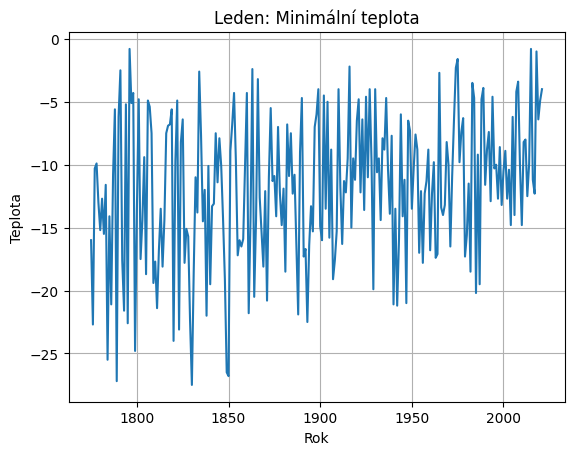

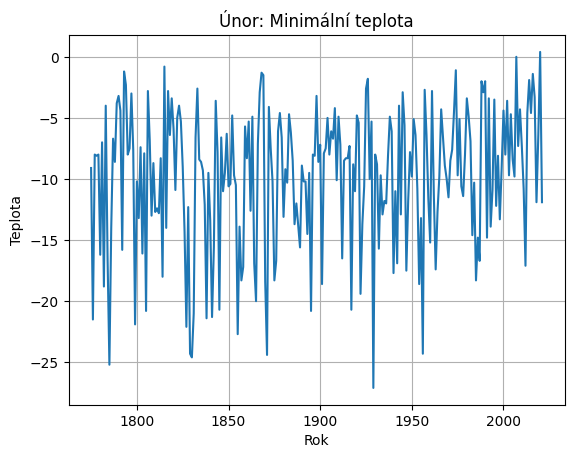

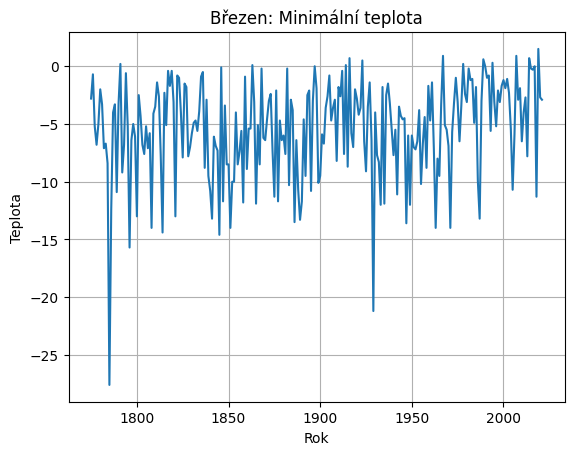

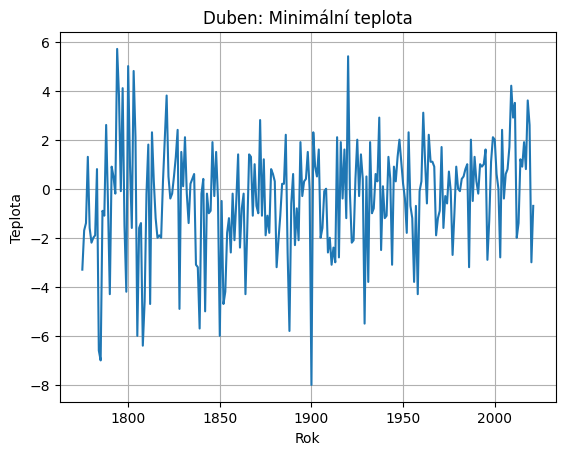

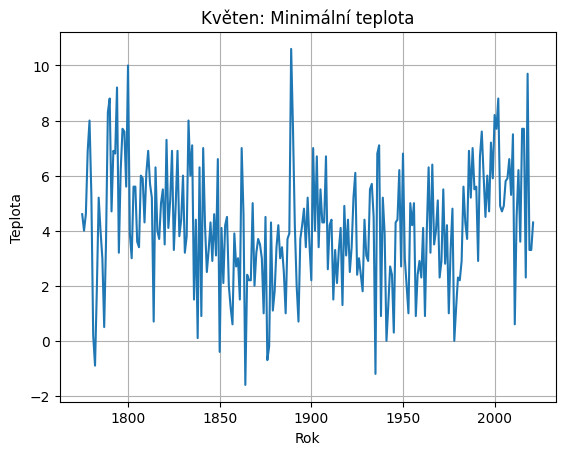

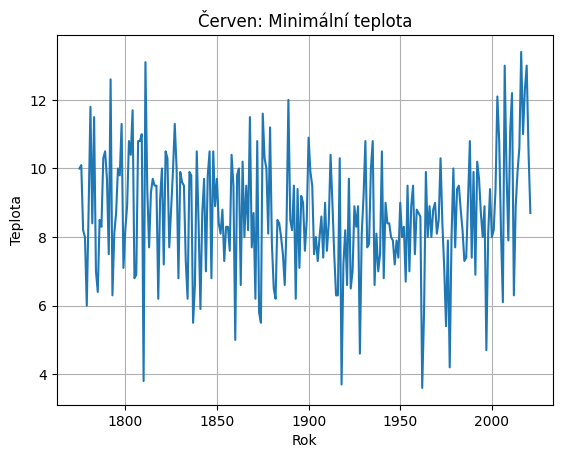

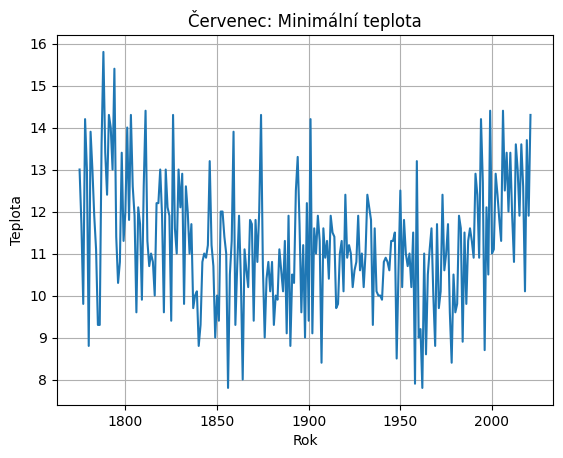

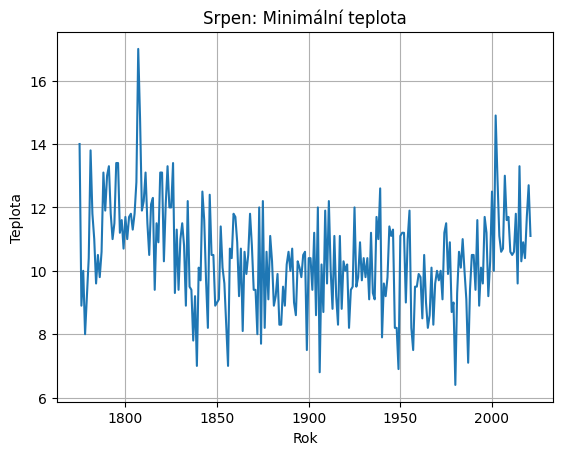

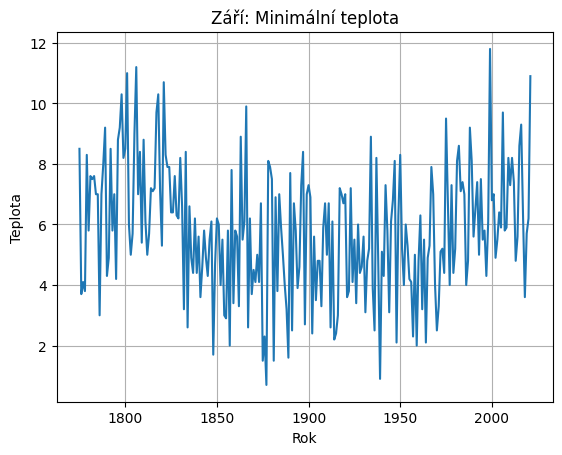

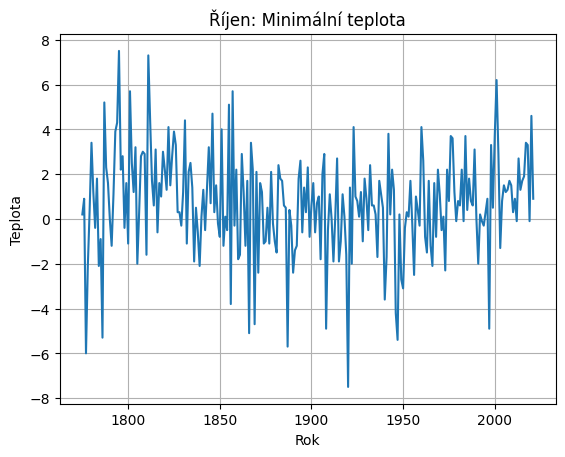

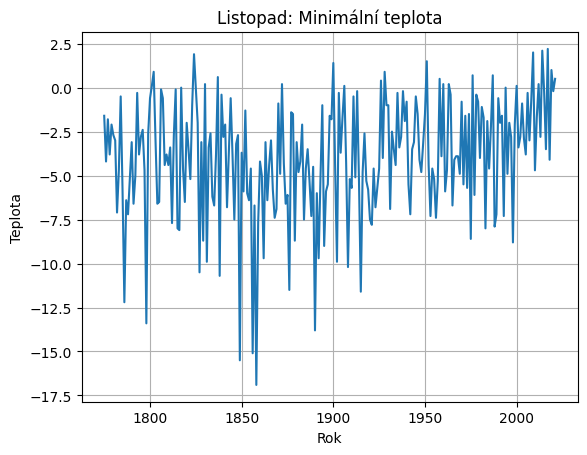

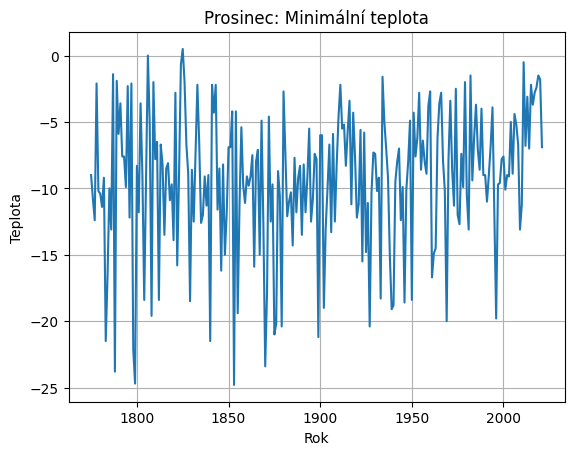

In [21]:
for i in 1:12
    figure()
    tmp = min_months[(i)]
    plot(tmp[:, :rok], tmp[:, :TMI])
    xlabel("Rok")
    ylabel("Teplota")
    title(Helpers.getMonth(i)*": Minimální teplota")
    grid()
    plt[:show]()
end

## Diskuse

* Na datech často pozoruji růst teploty v posledních 50ti letech

## Oceány

#### Nejdříve jsem v bashi zpracoval soubor na formát csv
echo Year,Month,col1,col2,col3,col4,col5,col6,col7,col8 > data/new_oceans.csv

cat data/aravg.mon.ocean.90S.90N.v5.0.0.202210.asc | tr -s " " ',' >> data/new_oceans.csv

In [22]:
df = CSV.read("./data/new_oceans.csv", DataFrame)
first(df, 5)

,Year,Month,col1,col2,col3,col4,col5,col6,col7
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1880,1,-0.269035,0.002906,0.0003,0.00085,0.001757,0.101046,0.075116
2,1880,2,-0.28632,0.002758,0.000225,0.00085,0.001683,0.088179,0.068918
3,1880,3,-0.207619,0.002879,0.000225,0.00085,0.001805,0.090243,0.032881
4,1880,4,-0.215785,0.002921,0.000225,0.00085,0.001846,0.086466,0.040121
5,1880,5,-0.352485,0.002904,0.000232,0.00085,0.001822,0.078583,0.056958


### Vytvoření nového sloupce obsahujícího průměrné hodnoty oceánů v letech

In [23]:
df[!, :AVG] = (df.col1 .+ df.col2 .+ df.col3 .+ df.col4 .+ df.col5 .+ df.col6 .+ df.col7)./7
first(df[:, [:Year, :Month, :AVG]], 5)

,Year,Month,AVG
,Int64,Int64,Float64
1,1880,1,-0.0124371
2,1880,2,-0.0176724
3,1880,3,-0.011248
4,1880,4,-0.011908
5,1880,5,-0.0301623


### Zahození původních sloupců

In [24]:
df = df[:, [:Year, :Month, :AVG]]
first(df, 5)

,Year,Month,AVG
,Int64,Int64,Float64
1,1880,1,-0.0124371
2,1880,2,-0.0176724
3,1880,3,-0.011248
4,1880,4,-0.011908
5,1880,5,-0.0301623


### Výpočet celkové průměrné teploty oceánů

In [25]:
avg_value = mean(df[:, :AVG])
avg_all = [ avg_value for x in 1:nrow(df) ]
avg_value

-0.00287519811635273

### Vizualizace odchylky průměrné teploty oceánů v letech od celkové průměrné teploty oceánů

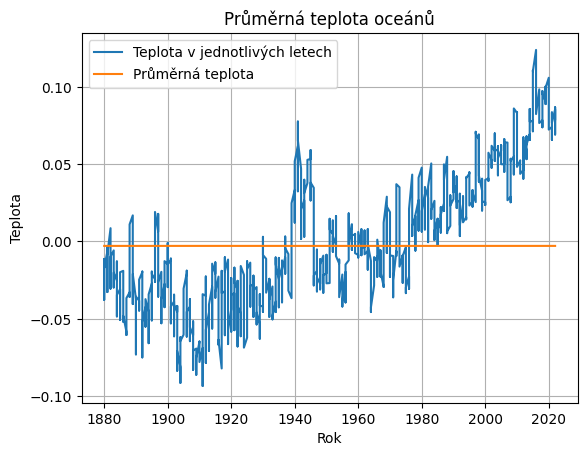

In [26]:
figure()
plot(df[:, :Year], df[:, :AVG], label="Teplota v jednotlivých letech")
plot(df[:, :Year], avg_all, label="Průměrná teplota")
xlabel("Rok")
ylabel("Teplota")
title("Průměrná teplota oceánů")
grid()
legend()
plt[:show]()

### Jaký model vystihuje data nejlépe?

* Jako vysvětlovanou proměnnou zvolím AVG teplotu

#### Příprava dat pro trénování

In [27]:
xs = Float64[x for x in df[:, :Year]] # přetypování příznaku Year na stejný jako CO2
ys = df[:, :AVG]
ws = ones(nrow(df)) # váhy datových bodů
fs_lin = [ x -> 1, x -> x ] # lineární funkce
fs_quad = [ x -> 1, x -> x, x -> x ^ 2 ] # kvadratická funkce

3-element Vector{Function}:
 #23 (generic function with 1 method)
 #24 (generic function with 1 method)
 #25 (generic function with 1 method)

#### Natrénování koeficientů lineární a kvadratické funkce odhadující příznak AVG

In [28]:
fit_lin = Helpers.fitWLS(xs, ys, ws, fs_lin) 
println("Koeficienty lineární funkce:\n", fit_lin)
fit_quad = Helpers.fitWLS(xs, ys, ws, fs_quad)
println("Koeficienty kvadratické funkce:\n", fit_quad)

Koeficienty lineární funkce:
[-1.6688521604724182, 0.0008539455198878117]
Koeficienty kvadratické funkce:
[30.04726666654925, -0.03167462038983961, 8.336730693348429e-6]


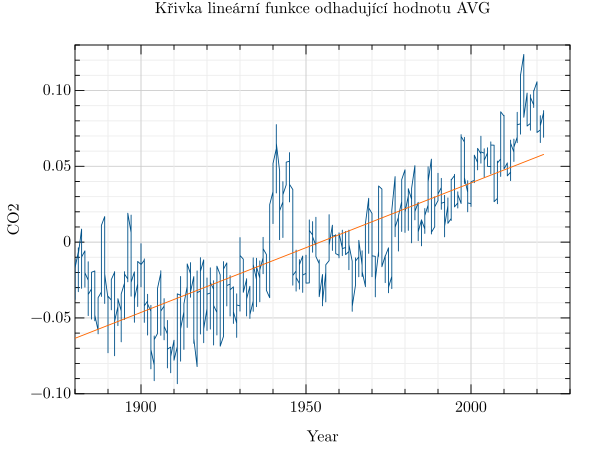

In [29]:
GR.title("Křivka lineární funkce odhadující hodnotu AVG")
GR.scatter(xs, ys)
GR.xlabel("Year")
GR.ylabel("CO2")
GR.oplot(xs, [ fit_lin[1] + fit_lin[2] * x for x in xs ])

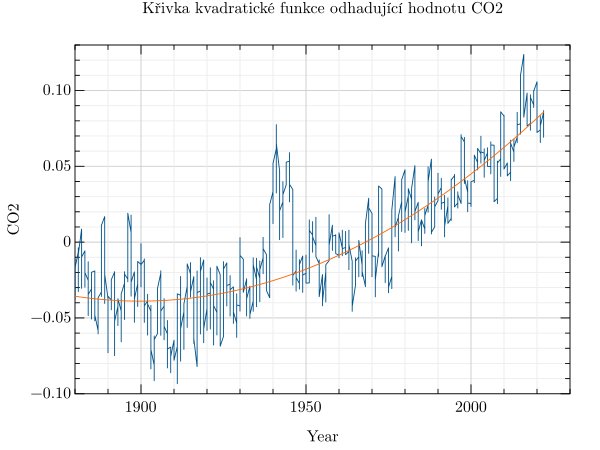

In [30]:
GR.title("Křivka kvadratické funkce odhadující hodnotu CO2")
GR.scatter(xs, ys)
GR.xlabel("Year")
GR.ylabel("CO2")
GR.oplot(xs, [ fit_quad[1] + fit_quad[2] * x + fit_quad[3] * x ^ 2 for x in xs ])

* Na první pohled se zdá, že kvadratická funkce opět lépe vystihuje trend růstu teploty v oceánech